# QCoDeS Example with Yokogawa GS200 and Keithley 7510 Multimeter

In this example, we will show how to use the Yokogawa GS200 smu and keithley 7510 dmm to perform a sweep measurement. The GS200 smu will source current through a 10 Ohm resistor using the **program** feature, and **trigger** the the 7510 dmm, which will measure the voltage across the resistor by **digitize** function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.measurements import Measurement

from qcodes.instrument_drivers.yokogawa.GS200 import GS200
from qcodes.instrument_drivers.tektronix.keithley_7510 import Keithley7510

In [2]:
gs = GS200("gs200", 'USB0::0x0B21::0x0039::91W434594::INSTR')
dmm = Keithley7510("dmm_7510", 'USB0::0x05E6::0x7510::04450961::INSTR')

Connected to: YOKOGAWA GS210 (serial:91W434594, firmware:2.02) in 0.06s
Connected to: KEITHLEY INSTRUMENTS DMM7510 (serial:04450961, firmware:1.6.7d) in 0.04s


In [3]:
gs.reset()
dmm.reset()

## 1. GS200 setup

to set the source mode to be "current" (by default it's "votage"), and set the current range and votlage limit.

In [4]:
gs.source_mode('CURR')
gs.current(0)
gs.current_range(.01)
gs.voltage_limit(5)

By default, the output should be off:

In [5]:
gs.output()

'off'

### 1.1 Trigger Settings

The BNC port will be use for triggering out. There are three different settings for trigger out signal:

• **Trigger** (default)

This pin transmits the TrigBusy signal. A low-level signal upon trigger generation and a
high-level signal upon source operation completion.

• **Output**

This pin transmits the output state. A high-level signal if the output is off and a lowlevel
signal if the output is on.

• **Ready**

This pin transmits the source change completion signal (Ready). This is transmitted
10 ms after the source level changes as a low pulse with a width of 10 μs.

In [6]:
print(f'By default, the setting for BNC trigger out is "{gs.BNC_out()}".')

By default, the setting for BNC trigger out is "TRIG".


### 1.2 Program the sweep

The GS200 does not have a build-in "sweep" function, but the "program" feature can generate a source data pattern that user specified as a program in advance.

A simple program, in which the current changes first to 0.01A, then -0.01A, and returns to 0A:

In [7]:
gs.program.start() # Starts program memory editing
gs.current(0.01)
gs.current(-0.01)
gs.current(0.0)
gs.program.end()  # Ends program memory editing

It can be save to the system memory (memory of the GS200):

In [8]:
gs.program.save('test1_up_and_down.csv')

The advantage of saving to the memory is that the user can have different pattern stored:

In [9]:
gs.program.start() # Starts program memory editing
gs.current(0.01)
gs.current(-0.01)
gs.current(0.005)
gs.current(0.0)
gs.program.end()  # Ends program memory editing

In [10]:
gs.program.save('test2_up_down_up.csv')

Let's load the first one:

In [11]:
gs.program.load('test1_up_and_down.csv')

The interval time between each value is set as following:

In [12]:
gs.program.interval(.1)
print(f'The interval time is {float(gs.program.interval())} s')

The interval time is 0.1 s


By default, the change is "instant", so the output would be like the following:

Text(0, 0.5, 'source current(A)')

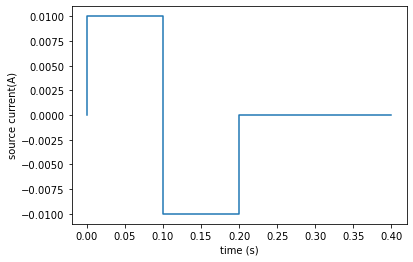

In [13]:
t_axis = [0, 0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.4]
curr_axis = [0, 0.01, 0.01, -0.01, -0.01, 0, 0, 0]
plt.plot(t_axis, curr_axis)
plt.xlabel('time (s)')
plt.ylabel('source current(A)')

But we want to introduce a "slope" between each source values: (see the user's manual for more examples of the slope time)

In [14]:
gs.program.slope(.1)
print(f'The slope time is {float(gs.program.slope())} s')

The slope time is 0.1 s


As a result, the expected output current should be:

Text(0, 0.5, 'source current(A)')

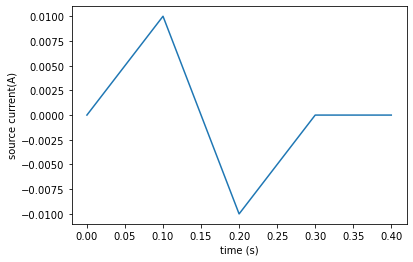

In [15]:
t_axis = [0, 0.1, 0.2, 0.3, 0.4]
curr_axis = [0, 0.01, -0.01, 0, 0]
plt.plot(t_axis, curr_axis)
plt.xlabel('time (s)')
plt.ylabel('source current(A)')

By default, the GS200 will keep repeating this pattern once it starts:

In [16]:
gs.program.repeat()

'ON'

We only want it to generate the pattern once:

In [17]:
gs.program.repeat('OFF')
print(f'The program repetition mode is now {gs.program.repeat()}.')

The program repetition mode is now OFF.


Note: at this moment, the output of the GS200 should still be off:

In [18]:
gs.output()

'off'

## 2. Keithley 7510 Setup

### 2.1 Setup basic digitize mode

The DMM7510 digitize functions make fast, predictably spaced measurements. The speed, sensitivity, and bandwidth of the digitize functions allows you to make accurate voltage and current readings of fast signals, such as those associated with sensors, audio, medical devices, power line issues, and industrial processes. The digitize functions can provide 1,000,000 readings per second at 4½ digits.

To set the digitize function to measure voltage, and the range. 

In [19]:
dmm.digi_sense_function('voltage')
dmm.digi_sense.range(10)

The system will determines when the 10 MΩ input divider is enabled: (for voltage measurement only)

In [20]:
dmm.digi_sense.input_impedance('AUTO')

To define the precise acquisition rate at which the digitizing measurements are made: (this is for digitize mode only)

In [21]:
readings_per_second = 10000
dmm.digi_sense.acq_rate(readings_per_second)
print(f'The acquisition rate is {dmm.digi_sense.acq_rate()} digitizing measurements per second.')

The acquisition rate is 10000 digitizing measurements per second.


We will let the system to decide the aperture size:

In [22]:
dmm.digi_sense.aperture('AUTO')

In [23]:
number_of_readings = 4000
dmm.digi_sense.count(number_of_readings)
print(f'{dmm.digi_sense.count()} measurements will be made every time the digitize function is triggered.')

4000 measurements will be made every time the digitize function is triggered.


### 2.2 Use an user buffer to store the data

In [24]:
buffer_name = 'userbuff01'
buffer_size = 100000
buffer = dmm.buffer(buffer_name, buffer_size)

In [25]:
print(f'The user buffer "{buffer.short_name}" can store {buffer.size()} readings, which is more than enough for this example.')

The user buffer "userbuff01" can store 100000 readings, which is more than enough for this example.


One of the benefits of the large size is: base on the settings above, the GS200 will send more than one trigger to the 7510. Technically, once a trigger is received, the 7510 unit would ignore any other trigger until it returns to idle. However, in reality it may still response to more than the first trigger. A large size will prevent the data in the buffer from being overwritten.

In [26]:
print(f'There are {buffer.last_index() - buffer.first_index()} readings in the buffer.')

There are 0 readings in the buffer.


### 2.3 Setup the tigger in

By default, the falling edge will be used to trigger the measurement:

In [27]:
dmm.trigger_in_ext_edge()

'FALL'

In [28]:
dmm.digitize_trigger()

'NONE'

We want an external trigger to trigger the measurement:

In [29]:
dmm.digitize_trigger('external')
dmm.digitize_trigger()

'EXT'

## 3. Check for errors

In [30]:
while True:
    smu_error = gs.system_errors()
    if 'No error' in smu_error:
        break
    print(smu_error)

In [31]:
while True:
    dmm_error = dmm.system_errors()
    if 'No error' in dmm_error:
        break
    print(dmm_error)

## 4. Make the measurement

To clear the external trigger in, and clear the buffer:

In [32]:
dmm.trigger_in_ext_clear()
buffer.clear_buffer()

In [33]:
total_data_points = int(buffer.number_of_readings())
print(f'there are total {total_data_points} readings in the buffer "{buffer.short_name}"')

there are total 0 readings in the buffer "userbuff01"


Perform the measurement by turning the GS200 on and run the program:

In [34]:
sleep_time = 1  # a sleep time is required, or the GS200 will turn off right away, and won't run the whole program
with gs.output.set_to('on'):
    gs.program.run()
    time.sleep(sleep_time)

The GS200 should be off after running:

In [35]:
gs.output()

'off'

In [36]:
total_data_points = int(buffer.number_of_readings())
print(f'there are total {total_data_points} readings, so the measurement was performed {round(total_data_points/4000, 2)} times')

there are total 8000 readings, so the measurement was performed 2.0 times


Let's use a time series as the setpoints:

In [37]:
dt = 1/readings_per_second
t0 = 0
t1 = (total_data_points-1)*dt

In [38]:
buffer.set_setpoints(start=buffer.t_start, stop=buffer.t_stop, label='time')
buffer.t_start(t0)
buffer.t_stop(t1)

To set number of points by specifying the data_start point and data_end point for the buffer:

In [39]:
buffer.data_start(1)
buffer.data_end(total_data_points)

`n_pts` is read only:

In [40]:
buffer.n_pts()

8000

The setpoints:

In [41]:
buffer.setpoints()

array([0.000e+00, 1.000e-04, 2.000e-04, ..., 7.997e-01, 7.998e-01,
       7.999e-01])

The following are the available elements that saved to the buffer:

In [42]:
buffer.available_elements

{'date',
 'fractional_seconds',
 'measurement',
 'measurement_formatted',
 'measurement_status',
 'measurement_unit',
 'relative_time',
 'seconds',
 'time',
 'timestamp'}

User can select multiple ones:

In [43]:
buffer.elements(['measurement', 'relative_time'])
buffer.elements()

['measurement', 'relative_time']

In [44]:
meas = Measurement()
meas.register_parameter(buffer.data)

with meas.run() as datasaver:
    data = buffer.data
    datasaver.add_result((buffer.data, data()))
    
    dataid = datasaver.run_id

Starting experimental run with id: 133. 


([<matplotlib.axes._subplots.AxesSubplot at 0x214941e8e48>,
 [None, None])

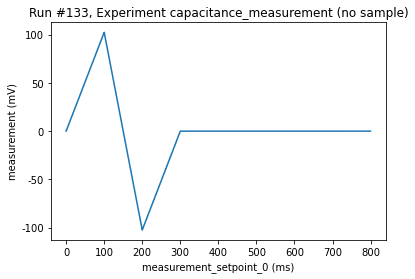

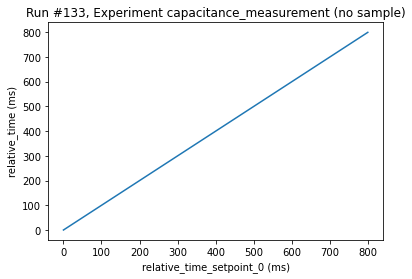

In [45]:
plot_dataset(datasaver.dataset)

(The second plot is t-t plot so a straight line.)

In [46]:
dataset = datasaver.dataset
dataset.get_parameter_data()

{'measurement': {'measurement': array([3.030936e-05, 2.576296e-05, 2.288357e-04, ..., 2.727843e-05,
         3.334030e-05, 2.576296e-05]),
  'measurement_setpoint_0': array([0.000e+00, 1.000e-04, 2.000e-04, ..., 7.997e-01, 7.998e-01,
         7.999e-01])},
 'relative_time': {'relative_time': array([0.000000e+00, 1.000010e-04, 2.000020e-04, ..., 7.997036e-01,
         7.998036e-01, 7.999036e-01]),
  'relative_time_setpoint_0': array([0.000e+00, 1.000e-04, 2.000e-04, ..., 7.997e-01, 7.998e-01,
         7.999e-01])}}

### Load previously saved pattern (GS200)

Remember we had another pattern stored? Let's load that one:

In [47]:
gs.program.load('test2_up_down_up.csv')

To clear the buffer, and external trigger in for the dmm:

In [48]:
dmm.trigger_in_ext_clear()
buffer.clear_buffer()

In [49]:
total_data_points = int(buffer.number_of_readings())
print(f'there are total {total_data_points} readings in the buffer "{buffer.short_name}"')

there are total 0 readings in the buffer "userbuff01"


In [50]:
sleep_time = 1
with gs.output.set_to('on'):
    gs.program.run()
    time.sleep(sleep_time)

In [51]:
total_data_points = int(buffer.number_of_readings())
print(f'there are total {total_data_points} readings, so the measurement was performed {round(total_data_points/4000, 2)} times')

there are total 8000 readings, so the measurement was performed 2.0 times


In [52]:
buffer.elements()

['measurement', 'relative_time']

In [53]:
meas = Measurement()
meas.register_parameter(buffer.data)

with meas.run() as datasaver:
    data = buffer.data
    datasaver.add_result((buffer.data, data()))
    
    dataid = datasaver.run_id

Starting experimental run with id: 134. 


([<matplotlib.axes._subplots.AxesSubplot at 0x214959c4688>,
 [None, None])

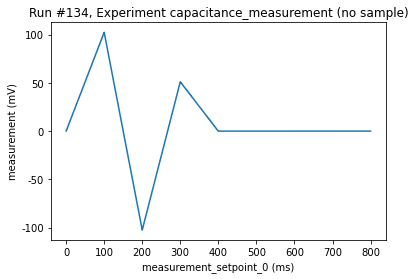

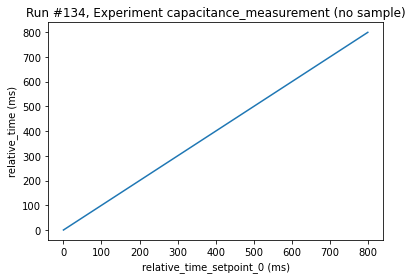

In [54]:
plot_dataset(datasaver.dataset)

In [55]:
gs.reset()
dmm.reset()